## Toy Model sampling discrete phases with reversible jump
In this example, reversible jump is used to determine which labels should be on. Phase angles are also sampled but the proposal distribution is discrete. They can only take on a value of 0 or 180. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import numpy as np
from parmed.topologyobjects import DihedralType
from simtk import unit
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db

In [2]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1), n_increments=30, 
              sample_phase=True, rj=True)

Generate toy model that only allows discrete phase proposals of 0 and 180

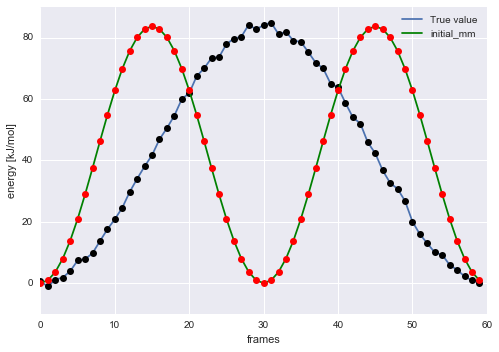

In [2]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1), n_increments=30, 
              sample_phase=True, rj=True)
plt.plot(toy.synthetic_energy, label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

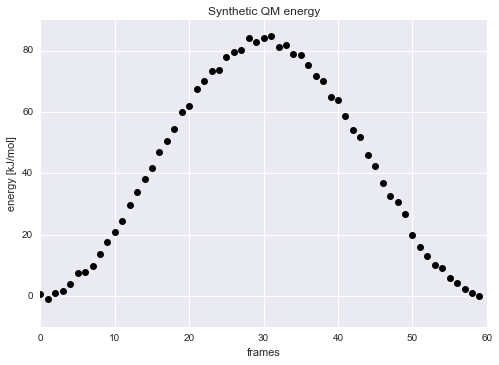

In [3]:
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.title('Synthetic QM energy')
plt.savefig('toy_QM_energy.pdf')

In [4]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='discrete_phase_rj.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 570.8 sec

In [3]:
sampler = db.load('discrete_phase_rj.sqlite')

In [6]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)
print(toy.model.pymc_parameters['CG331_CG321_CG321_CG331_1_K'].value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>
9.983119186832202


### Energy (Likelihood).
To check the fit, let's look how well the sampled parameters reproduce the energy of the True values. 
The fit looks pretty good!

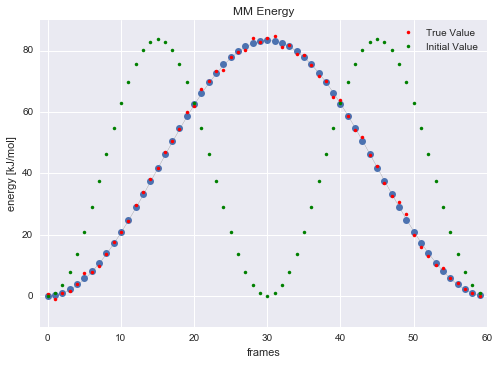

In [40]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.legend()
plt.savefig('energy_fit_discrete.pdf')

### How many samples does it take for the sampler to become consistent?
Ideally, the convergence of the slowest converging parameter should be looked at to check if the sampler is converged. However, since we are using reversible jump to sample the labels that determine if a term in the Fourier series is on or off, the parameter will randomly explore the phase space when the label is off so when the label turns back on, it's as if the chain restarts. Therefore, I look at sigma. Sigma is a nuisance parameter of the Gaussian error model (likelihood). 

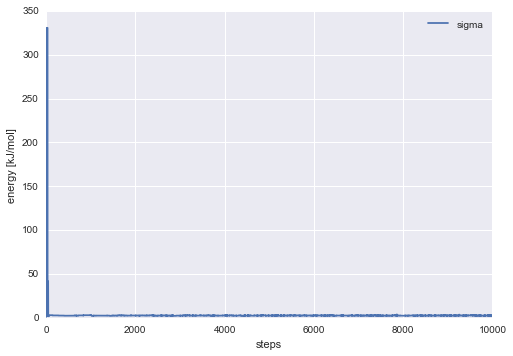

In [19]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.savefig('sigma_discrete.pdf')

Use pymbar's equilibration detection to determine when sigma has 'equilibrated'

In [12]:
import pymbar.timeseries as ts
[t, g, N_eff] = ts.detectEquilibration(sampler.trace('sigma')[:])

In [14]:
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 30


### Marginal distribution of labels
As expected, label 1 is the most likely to be on. 

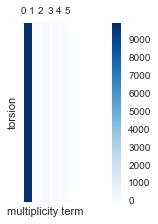

In [4]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, 0)
plt.savefig('multiplicity_discrete.pdf')

### Traces of parameters
When the label is on, the values of the force constant (K) and phase angle converges to the true value. If the label is off, the values for K and phase are random since they don't contribute to the energy.

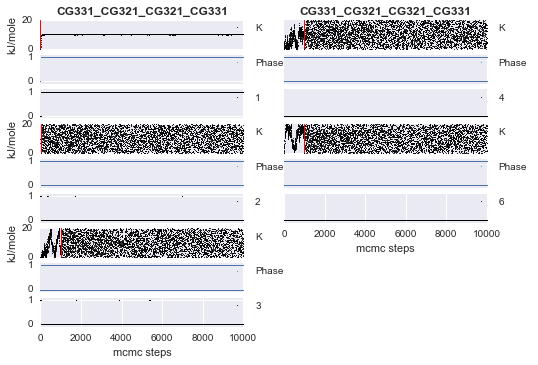

In [23]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, filename='traces_discrete_rj.pdf')

### Marginal distribution of parameters
The distribution of $K_1$ is tightly distributed around the true value, while all other K's are uniformly distributed.

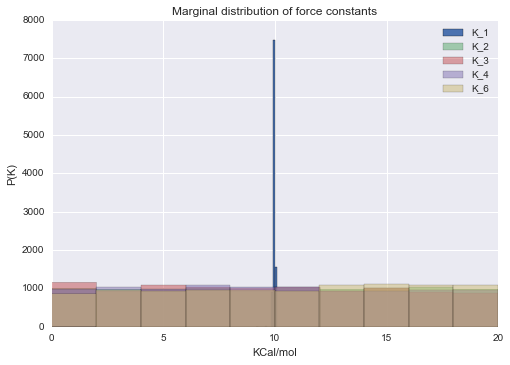

In [31]:
alpha = 0.5
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[30:], label='K_1')
plt.hist(sampler.CG331_CG321_CG321_CG331_2_K.trace[30:], label='K_2', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_K.trace[30:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_K.trace[30:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_K.trace[30:], label='K_6', alpha=alpha)

plt.legend()
plt.title('Marginal distribution of force constants')
plt.xlabel('KCal/mol')
plt.ylabel('P(K)')

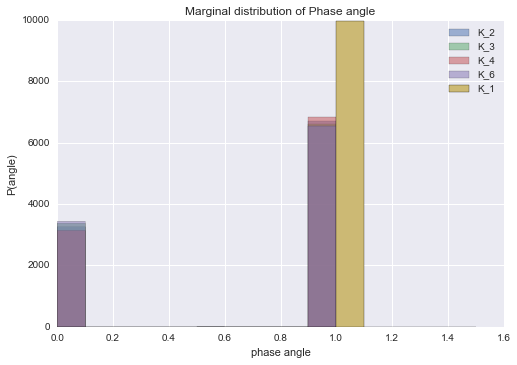

In [34]:
alpha = 0.5
plt.hist(sampler.CG331_CG321_CG321_CG331_2_Phase.trace[30:], label='K_2', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_Phase.trace[30:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_Phase.trace[30:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_Phase.trace[30:], label='K_6', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_Phase.trace[30:], label='K_1')


plt.legend()
plt.title('Marginal distribution of Phase angle')
plt.xlabel('phase angle')
plt.ylabel('P(angle)')

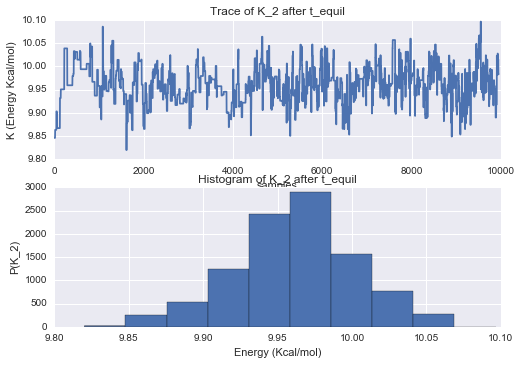

In [39]:
plt.subplot(2, 1, 1)
plt.title('Trace of K_2 after t_equil')
plt.plot(sampler.CG331_CG321_CG321_CG331_1_K.trace[t+20:])
plt.xlabel('samples')
plt.ylabel('K (Energy Kcal/mol)')
plt.subplot(2, 1, 2)
plt.title('Histogram of K_2 after t_equil')
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t+20:], label='K_2')
plt.xlabel('Energy (Kcal/mol)')
plt.ylabel('P(K_2)')
plt.savefig('trace_hist_label_on.pdf')